In [ ]:
#!pip install datasets transformers nltk keras tensorflow numpy

In [1]:
import re
import nltk
from nltk.corpus import stopwords
from bs4 import BeautifulSoup

# Download NLTK stopwords if not already downloaded
nltk.download('stopwords')

# Text cleaning function
def clean_text(text):
    # Check if the input is a string
    if not isinstance(text, str):
        raise ValueError("Input text must be a string")

    # Remove HTML tags
    try:
        # Ensure the text is treated as HTML markup
        if text.strip():  # Check if the text is not empty or whitespace
            text = BeautifulSoup(text, "html.parser").get_text()
        else:
            text = ""  # Return an empty string if the input is empty
    except Exception as e:
        print(f"Error parsing HTML: {e}")
        return text

    # Remove non-alphabetic characters and punctuation
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Convert to lowercase
    text = text.lower()

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])

    return text

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from datasets import load_dataset

# Load dataset
df = pd.read_csv('IMDB Dataset.csv')

# Apply cleaning function
df['review'] = df['review'].apply(clean_text)

# Tokenization
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(df['review'])
sequences = tokenizer.texts_to_sequences(df['review'])
data = pad_sequences(sequences, maxlen=250)

# Convert labels to numerical values
df['sentiment'] = df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

# Split data
X_train, X_val, y_train, y_val = train_test_split(data, df['sentiment'], test_size=0.2, random_state=42)

/tmp/ipykernel_38760/1669008680.py:19: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()


In [14]:
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Embedding, LSTM, Dense, Bidirectional, Layer

class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='att_weight', shape=(input_shape[-1], input_shape[-1]), initializer='glorot_uniform', trainable=True)
        self.b = self.add_weight(name='att_bias', shape=(input_shape[-1],), initializer='zeros', trainable=True)
        self.u = self.add_weight(name='att_context_vector', shape=(input_shape[-1],), initializer='glorot_uniform', trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        # Compute the attention scores
        u_t = tf.tanh(tf.tensordot(x, self.W, axes=1) + self.b)
        a_t = tf.tensordot(u_t, self.u, axes=1)
        a_t = tf.nn.softmax(a_t, axis=1)

        # Apply the attention weights to the input tensor
        output = x * tf.expand_dims(a_t, -1)
        output = tf.reduce_sum(output, axis=1)

        return output

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])

# Model definition
input_layer = Input(shape=(250,))
embedding_layer = Embedding(input_dim=10000, output_dim=128, input_length=250)(input_layer)
lstm_layer = Bidirectional(LSTM(64, return_sequences=True))(embedding_layer)
attention_layer = AttentionLayer()(lstm_layer)
output_layer = Dense(1, activation='sigmoid')(attention_layer)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [15]:
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 250)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_4 (Embedding)         │ (None, 250, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 250, 128)       │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer_4               │ (None, 128)            │        16,640 │
│ (AttentionLayer)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,395,585 (5.32 MB)

 Trainable params: 1,395,585 (5.32 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_val, y_val))

Epoch 1/5


2024-09-12 12:55:33.503825: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 40000000 exceeds 10% of free system memory.


625/625 ━━━━━━━━━━━━━━━━━━━━ 219s 346ms/step - accuracy: 0.7762 - loss: 0.4301 - val_accuracy: 0.8883 - val_loss: 0.2712
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 264s 349ms/step - accuracy: 0.9229 - loss: 0.2057 - val_accuracy: 0.8878 - val_loss: 0.2739
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 260s 346ms/step - accuracy: 0.9496 - loss: 0.1435 - val_accuracy: 0.8772 - val_loss: 0.3153
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 259s 341ms/step - accuracy: 0.9684 - loss: 0.0953 - val_accuracy: 0.8775 - val_loss: 0.3721
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 267s 350ms/step - accuracy: 0.9782 - loss: 0.0696 - val_accuracy: 0.8717 - val_loss: 0.4160


313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step
              precision    recall  f1-score   support

           0       0.88      0.86      0.87      4961
           1       0.86      0.89      0.87      5039

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



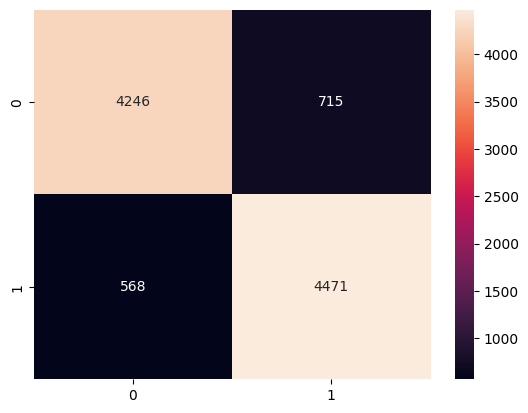

In [17]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predictions
y_pred = (model.predict(X_val) > 0.5).astype("int32")

# Evaluation
print(classification_report(y_val, y_pred))

cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()